Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Szuba"

---

# 3. Grupowo ekwiwariantne sieci konwolucyjne
Ostatnią architekturą, którą dzisiaj sprawdzimy są tzw. *Group Equivariant Neural Networks*, czyli sieci neuronowe (w naszym przypadku konwolucyjne), które opisują funkcje ekwiwariantne względem określonej grupy symetrii. Po raz pierwszy koncepcja takich sieci została opisana w 2016 r. przez Cohena i Wellinga w pracy [Group Equivariant Convolutional Networks](https://arxiv.org/pdf/1602.07576.pdf). W pracy formalizują zastosowanie grup symetrii do modelowania struktury danych – dokładniej mówiąc rozważają dwie grupy: *p4* (obroty o 90 stopni) oraz *p4m* (obroty o 90 stopni i odbicia). 


Implementacja grupowo ekwiwariantnych sieci jest zadaniem nietrywialnym i czasochłonnym, stąd w tym zeszycie wykorzystamy bibliotekę `e2cnn`, która posiada zaimplementowane warstwy grupowo ekwiwariantne.

In [2]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

## 3.1. Architektura
Założeniem modelu będzie, aby koder był w stanie stworzyć niezmienniczą (ang. *invariant*) reprezentację podstawowych i obróconych obrazów wejściowych. Moduł dekodera nie będziemy modyfikować i użyjemy klasy `CNNDecoder` z poprzedniego zeszytu. 

## Zadanie 3.1. (4 pkt)
W celu zrozumienia grupowo ekwiwariantnych sieci zaleca się zapoznanie z poniższymi materiałami:
- [2-częściowy blog na temat G-CNN](https://fabianfuchsml.github.io/equivariance1of2/)
- [Wykład Erika Bekkersa "Group Equivariant Deep Learning (UvA - 2022)" (Lecture 1.1-1.7)](https://youtube.com/playlist?list=PL8FnQMH2k7jzPrxqdYufoiYVHim8PyZWd)

Zapoznaj się z biblioteką E2CNN:
- [Przykład użycia](https://github.com/QUVA-Lab/e2cnn#getting-started)
- [Zeszyt wprowadzający](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/introduction.ipynb)

i zaimplementuj moduł kodera z następującą architekturą:
- dla każdej warstwy konwolucji przymij takie same parametry jak dla `CNNEncoder` z poprzedniego zeszytu, tzn. `kernel_size=3`, `stride=2`, `padding=1`
- pierwsza warstwa konwolucji obrotowej `R2Conv` obliczająca 8 filtrów wyjściowych
- aktywacja ReLU
- druga warstwa konwolucji obrotowej `R2Conv` obliczająca 16 filtrów wyjściowych
- aktywacja ReLU
- trzecia warstwa konwolucji obrotowej `R2Conv` obliczająca 32 filtry wyjściowe
- redukacja maksymalizująca (`PointwiseMaxPoolAntialiased`) z kernelem o wymiarze `3`
- redukcja grupowa (`GroupPooling`)
- część wielowarstwowego perceptrona z modelu `CNNEncoder`, tzn.:
    - spłaszczenie macierzy do wektora, 
    - warstwa liniowa z 128 cechami wyjściowymi
    - aktywacja ReLU
    - warstwa liniowa z `latent_dim` cechami wyjściowymi

Jako grupę symetrii przyjmij grupę obrotów dyskretnych, tzw. grupę cykliczną $C_N$ (`Rot2dOnR2`).

Pamiętaj użyciu właściwych modułów z pakietu `e2cnn.nn` oraz `torch.nn`.

In [3]:
from e2cnn import gspaces
from e2cnn import nn

import torch


class GCNNEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim: int, N: int):
        super().__init__()
        self.group = gspaces.Rot2dOnR2(N)
        self.layer1 = self._create_first_r2_conv(1, 1)
        self.layer2 = self._create_r2_conv(1, 2)
        self.layer3 = self._create_r2_conv(2, 4)
        
        feat_type_in = nn.FieldType(self.group, [self.group.regular_repr] * 4)
        self.pooling = nn.PointwiseMaxPoolAntialiased(feat_type_in, kernel_size=3)
        self.group_pooling = nn.GroupPooling(feat_type_in)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, latent_dim)
        )
        
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        feat_type_in = nn.FieldType(self.group, [self.group.trivial_repr] * 1)
        x = nn.GeometricTensor(img, feat_type_in)
        x = self.layer1(x)
        x = nn.ReLU(self._get_regular_type(1))(x)
        x = self.layer2(x)
        x = nn.ReLU(self._get_regular_type(2))(x)
        x = self.layer3(x)
        x = self.pooling(x)
        x = self.group_pooling(x)
        x = x.tensor
        
        x = self.mlp(x)
        
        return x
     
    def _get_regular_type(self, filters: int):
        return nn.FieldType(self.group, [self.group.regular_repr] * filters)
     
    def _create_first_r2_conv(self, in_filters: int, out_filters: int):
        feat_type_in = nn.FieldType(self.group, [self.group.trivial_repr] * in_filters)
        feat_type_out = self._get_regular_type(out_filters)
        return nn.R2Conv(
            feat_type_in,
            feat_type_out,
            kernel_size=3,
            stride=2,
            padding=1
        )  
        
    def _create_r2_conv(self, in_filters: int, out_filters: int):
        feat_type_in = self._get_regular_type(in_filters)
        feat_type_out = self._get_regular_type(out_filters)
        return nn.R2Conv(
            feat_type_in,
            feat_type_out,
            kernel_size=3,
            stride=2,
            padding=1
        )  

## 3.2. Uczenie modelu
W przeciwieństwie do poprzednich zeszytów, nie załączono wcześniej przygotowanego modelu, a uczenie należy przeprowadzić samemu. Uczenie powinno zająć kilkanaście/kilkadziesiąt minut, a w razie mocno ograniczonych zasobów należy skorzystać z Google Colab (aby wykorzystać GPU wystarczy przekazać odpowiedni parametr do `Trainer`, co jest opisane w dokumentacji: [Trainer API](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-class-api), [użycie GPU](https://lightning.ai/docs/pytorch/stable/accelerators/gpu_basic.html)).

In [8]:
LOG_PATH = "./data/GCNN/logs"
CHECKPOINT_PATH = "./data/GCNN/model.chkpt"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $LOG_PATH --host 0.0.0.0 --port 6006

In [4]:
from src.dataset import SampledMNISTData
from src.ae import Autoencoder
from src.cnn import CNNDecoder

c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(
c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
class GCNNAutoencoder(Autoencoder):
    
    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=GCNNEncoder(latent_dim=latent_dim, N=8),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )


In [9]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from src.dataset import SampledMNISTData


if not os.path.isfile(CHECKPOINT_PATH):
    # if already trained, load saved checkpoint
    # it is normal that some parameters are missing (difference is due to eval and train modes)
    #gcnn_ae = GCNNAutoencoder.load_from_checkpoint(CHECKPOINT_PATH, strict=False, latent_dim=2)
    pass
else:
    # train model otherwise
    gcnn_ae = GCNNAutoencoder(latent_dim=2)
    trainer = Trainer(
        max_epochs=10,
        logger=TensorBoardLogger(save_dir=LOG_PATH, name="gcnn_ae", default_hp_metric=False),
        callbacks=[]
    )
    mnist = SampledMNISTData(num_samples_per_class=-1)

    trainer.fit(
        model=gcnn_ae,
        train_dataloaders=mnist,
    )

    trainer.save_checkpoint(filepath=CHECKPOINT_PATH)

c:\Python311\Lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)
c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | _encoder | GCNNEncoder | 1.4 K 
1 | _decoder | CNNDecoder  | 43.4 K
-----------------------------------------
44.8 K    Trainable params
0         Non-trainable params
44.8 K    Total params
0.179     Total estimated model params size (M

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## 3.3. Badanie jakości reprezentacji w zadaniu

Wczytujemy losową próbkę zbioru danych MNIST:

In [10]:
mnist = SampledMNISTData(num_samples_per_class=100, seed=42)

Dla każdej próbki wyciągamy jej reprezentację (wektor dwu-wymiarowy) oraz etykietę:

In [11]:
from src.utils import extract_representations


representations = extract_representations(
    model=gcnn_ae,
    dataset=mnist,
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [12]:
from src.utils import evaluate_linear    


auc_train, auc_test = evaluate_linear(
    z_train=representations["train"]["z"],
    y_train=representations["train"]["y"],
    z_test=representations["test"]["z"],
    y_test=representations["test"]["y"],
)

print(f"AUC => train: {auc_train * 100.0:.2f} [%], test: {auc_test * 100.0:.2f} [%]")

AUC => train: 82.35 [%], test: 83.33 [%]


## 3.4. Wizualizacja przestrzeni reprezentacji

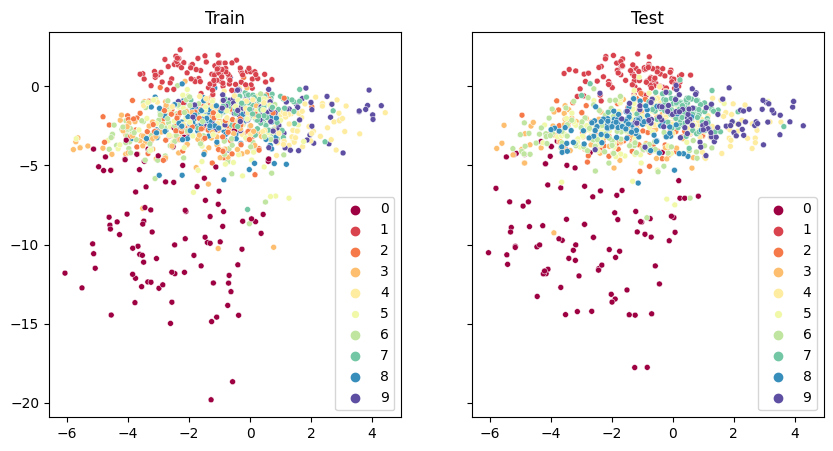

In [13]:
%matplotlib inline

from src.utils import visualize_latent_spaces


visualize_latent_spaces(representations)

## 3.5. Wizualizacja jakości rekonstrukcji

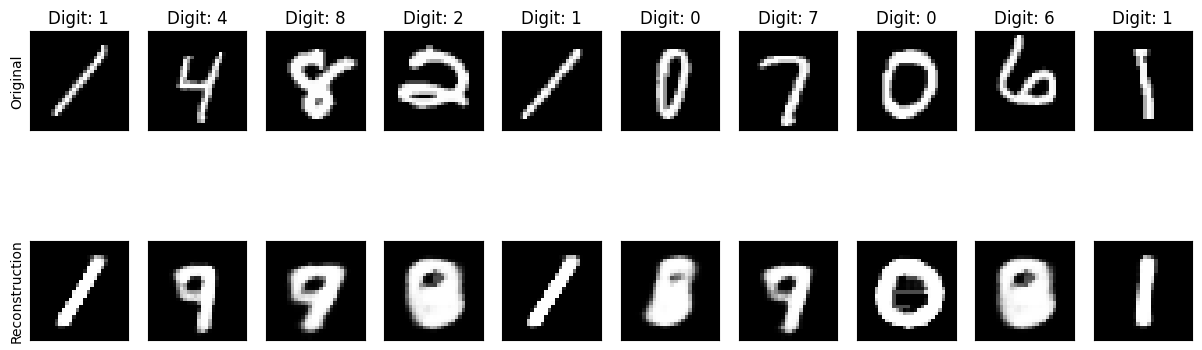

In [14]:
%matplotlib inline

from src.utils import visualize_random_sample

    
visualize_random_sample(model=gcnn_ae, dataset=mnist.mnist_train)

## 3.6. Odporność na obroty
Zbadamy jak się zachowuje model oparty o grupowo ekwiwariantne sieci konwolucyjne w przypadku obrotów.

Wybieramy dowolną instancję ze zbioru danych:

In [15]:
img, _ = mnist.mnist_train[256]

## Zadanie 3.3. (0 pkt)
Skopiuj implementację funkcji `rotate` z poprzedniego zeszytu.

In [16]:
import torch
import torchvision.transforms.functional as TF

def rotate(img: torch.Tensor, angle: float) -> torch.Tensor:
    if len(img.shape) == 2:
        img = img.unsqueeze(0)
    rotated_img = TF.rotate(img, angle)

    return rotated_img.squeeze()
    

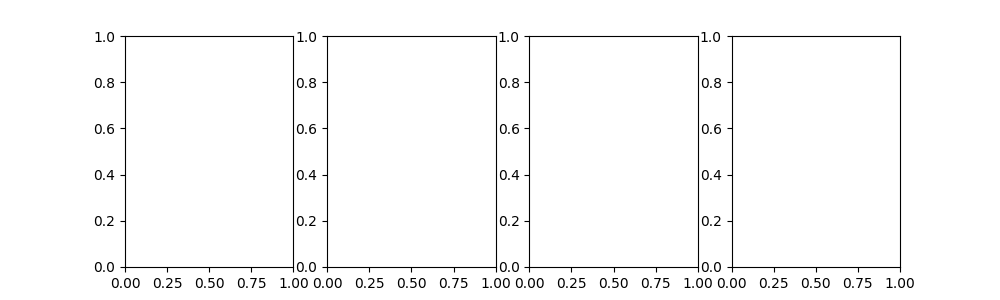

In [17]:
%matplotlib widget
from src.transforms import plot_transformation


plot_transformation(
    image=img,
    model=gcnn_ae,
    transformation_fn=rotate,
    min_param_value=0,
    max_param_value=360,
    step=45,
    keep_channel_dim=True,
)

## Zadanie 3.4 (1 pkt)
Czy autokoder G-CNN jest odporny na obroty obiektów? Z czego może to wynikać?

G-CNN (Geometric Convolutional Neural Network) to model sieci neuronowej, który wprowadza geometryczne przekształcenia do standardowej sieci konwolucyjnej. Może on być zaprojektowany tak, aby był odporny na obroty obiektów, co wynika z faktu, że każda warstwa sieci jest równoważna pod względem geometrii.

To oznacza, że jeśli obiekt na obrazie wejściowym jest obrócony, sieć powinna nadal być w stanie poprawnie go zidentyfikować, ponieważ każda warstwa sieci jest zaprojektowana tak, aby obsługiwać obroty obiektów. Ta cecha wynika z zastosowania konwolucji geometrycznych, które uwzględniają możliwość obrócenia filtrów konwolucyjnych.